In [1]:
import os
import pickle
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0, 0, 0
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / float(refTotal) if float(refTotal) > 0 else 0
    prec   = intersection / float(genTotal) if float(genTotal) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    
    return recall, prec, f1

class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(input_size, outputsize)
        
    def forward(self, bow_vec):
        return F.sigmoid(self.linear(bow_vec))


def buildPredSummary(df, summary, sentence_emb, curr_pred_emb, action, select_index, sent_index):
    if sent_index==0 and action.select(1, select_index).tolist()[0] == 1:
        return sentence_emb, summary + df['sentence'][sent_index]

    if action.select(1, select_index).tolist()[0] == 1:
        return (curr_pred_emb + sentence_emb)/2., curr_summary + ' ' + df['sentence'][sent_index]
    
    else:
        return sentence_emb, curr_summary

In [38]:
sdf = pd.read_csv('/home/francisco/GitHub/DQN-Event-Summarization/data/sif/train_000_0.csv')

# Initializing stuff

SKIP = 0
SELECT = 1

true_summary = sdf['summary'][0]
ts_tokenized = Counter(true_summary.split(" "))

nepochs = 1000
emb_d = 300
outputdim = 2
rand_rate = 0.50

lrate = 0.01
decay_rate = 0.01

model = BoWRegressor(emb_d, outputdim)
model.zero_grad()

criterion = nn.MSELoss()

In [39]:
optimizer = optim.SGD(model.parameters(), lr=lrate)
nsentences = sdf.index.max()

lossf = {'loss': [], 'sent_idx': [], 'epoch': [], 'action': [], 'f1': []}

for epoch in range(nepochs):
    model.zero_grad()
    
    # reset embeddings and summary at the start of training
    predsummary_emb = torch.from_numpy(np.zeros((1, emb_d))).float()
    curr_summary = ''
    f1_t0 = 0.
    
    for sent_index in range(nsentences):
        # The embeddings start on the 5th column (index 4)
        train_xs = torch.FloatTensor(sdf[sdf.columns[4:]].values[sent_index,:].reshape(1, emb_d))
        train_ys = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).float()
        action_ys = torch.from_numpy(np.asarray([0]).reshape(1,1)).float()
        action = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).int()

        rouge_preds = model(autograd.Variable(train_xs))
        
        qMax, qIndx = rouge_preds.max(dim=1)

        if np.random.uniform() > rand_rate and rand_rate > 0:
            # Randomly choosing either 0 or 1 some percent of hte time
            qIndx = np.random.randint(0, 2, 1)[0]

        action[:, qIndx.data[0]] = 1
        action[:, abs(qIndx.data[0] - 1)] = 0
        
        # building the summary and capturing the embedding
        predsummary_emb, curr_summary = buildPredSummary(
                                             sdf, 
                                             curr_summary, 
                                             train_xs, 
                                             predsummary_emb, 
                                             action, 
                                             SELECT, 
                                             sent_index
                                        )
        recall, prec, f1 = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
        # Backward part
        predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
        rouge_delta = f1 - f1_t0
        action_ys[0] = rouge_delta
        
        # Change in rouge-f1
        train_ys[:, qIndx.data[0]] = rouge_delta
        train_ys[:, abs(qIndx.data[0]-1)] = 0.

        loss = criterion(rouge_preds, autograd.Variable(train_ys))
        
        loss.backward()
        optimizer.step()
        
        lossf['loss'].append(loss.data[0])
        lossf['sent_idx'].append(sent_index)
        lossf['epoch'].append(epoch)
        lossf['action'].append(qIndx.data[0])
        lossf['f1'].append(f1)

        # Storing last round
        f1_t0 = f1 - f1_t0
        
    rand_rate -= decay_rate

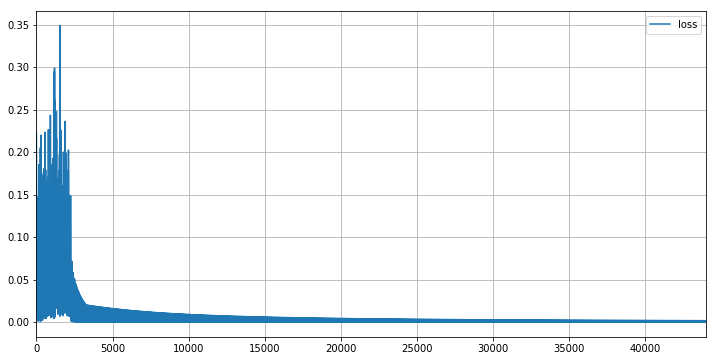

In [40]:
perf = pd.DataFrame(lossf)

perf.plot(y='loss', figsize=(12, 6))
plt.grid()
plt.show()

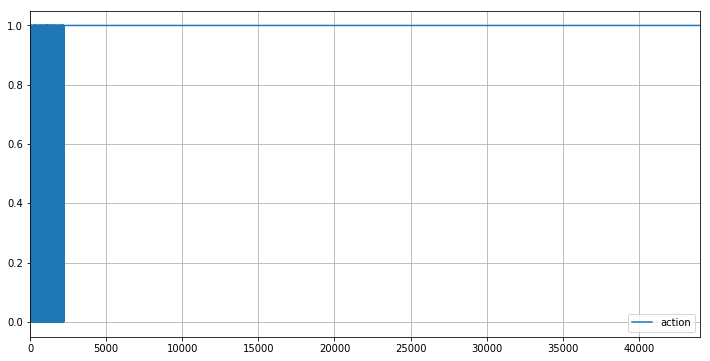

In [41]:
perf.plot(y='action', figsize=(12, 6))
plt.grid()
plt.show()

In [34]:
lead3 = ' '.join(sdf['sentence'][0:3])

finalsummary = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
baseline = rougeScores(ts_tokenized, Counter(lead3.split(" ")))

print("lead-3  recall = %.3f; precision = %.3f; f1-score = %.3f " % (baseline[0], baseline[1], baseline[2]))

print("learned recall = %.3f; precision = %.3f; f1-score = %.3f " % (finalsummary[0], finalsummary[1], finalsummary[2]))

lead-3  recall = 0.269; precision = 0.375; f1-score = 0.313 
learned recall = 0.049; precision = 0.833; f1-score = 0.093 


In [35]:
lead3

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial .'

In [36]:
true_summary

'mentally ill inmates in miami are housed on the forgotten floor. judge steven leifman says most are there as a result of avoidable felonies. while cnn tours facility patient shouts i am the son of the president. leifman says the system is unjust and he fighting for change.'

In [37]:
curr_summary

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial . miami , florida -lrb- cnn -rrb- -- the ninth floor of the miami-dade pretrial detention facility is dubbed the `` forgotten floor . \'\' here , inmates with the most severe mental illnesses are incarcerated until they \'re ready to appear in court . most often , they face drug charges or charges of assaulting an officer -- charges that judge steven leifman says are usually `` avoidable felonies . \'\' he says the arrests often result from confrontations with police . mentally ill people often wo n\'t do what they \'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become m

# TESTING

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lrate)
nsentences = sdf.index.max()

lossf = {'loss': [], 'sent_idx': [], 'epoch': [], 'action': [], 'f1': []}
epoch = 0
sent_index = 0
model.zero_grad()
    
# reset embeddings and summary at the start of training
predsummary_emb = torch.from_numpy(np.zeros((1, emb_d))).float()
curr_summary = ''
f1_t0 = 0.

In [ ]:
# The embeddings start on the 5th column (index 4)

train_xs = torch.FloatTensor(sdf[sdf.columns[4:]].values[sent_index,:].reshape(1, emb_d))
train_ys = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).float()
action_ys = torch.from_numpy(np.asarray([0]).reshape(1,1)).float()
action = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).int()

rouge_preds = model(autograd.Variable(train_xs))

qMax, qIndx = rouge_preds.max(dim=1)

action[:, qIndx.data[0]] = 1
action[:, abs(qIndx.data[0] - 1)] = 0

# building the summary and capturing the embedding
predsummary_emb, curr_summary = buildPredSummary(
                                     sdf, 
                                     curr_summary, 
                                     train_xs, 
                                     predsummary_emb, 
                                     action, 
                                     SELECT,
                                     sent_index
                                )

recall, prec, f1 = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))

In [ ]:
# Backward part

predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
action_ys[0] = f1 - f1_t0

# Storing last round
f1_t0 = f1 - f1_t0

#        # Change in rouge-f1
train_ys[:, qIndx.data[0]] = f1 - f1_t0
train_ys[:, abs(qIndx.data[0]-1)] = 0.

loss = criterion(rouge_preds, autograd.Variable(train_ys))

loss.backward()
optimizer.step()

lossf['loss'].append(loss.data[0])
lossf['sent_idx'].append(sent_index)
lossf['epoch'].append(epoch)
lossf['action'].append(qIndx.data[0])
lossf['f1'].append(f1)

rand_rate -= decay_rate

In [ ]:
sent_index+= 1

In [ ]:
curr_summary

In [ ]:
sdf['sentence'].head()

In [ ]:
# Backward part

predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
action_ys[0] = f1 - f1_t0

# Storing last round
f1_t0 = f1 - f1_t0

#        # Change in rouge-f1
train_ys[:, qIndx.data[0]] = f1 - f1_t0
train_ys[:, abs(qIndx.data[0]-1)] = 0.

loss = criterion(rouge_preds, autograd.Variable(train_ys))

loss.backward()
optimizer.step()

lossf['loss'].append(loss.data[0])
lossf['sent_idx'].append(sent_index)
lossf['epoch'].append(epoch)
lossf['action'].append(qIndx.data[0])
lossf['f1'].append(f1)

rand_rate -= decay_rate

# end testing 

In [ ]:
loss = mse(rouge_preds, autograd.Variable(train_ys))

In [ ]:
action = action.byte()

In [ ]:
optQ = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))

In [ ]:
loss.backward()

In [ ]:
dataloader = dl.TensorLoader({
                    queryMemory[{{1, memrows}}], 
                    sentenceMemory[{{1, memrows}}], 
                    predSummaryMemory[{{1, memrows}}], 
                    qPredsMemory[{{1, memrows}}], 
                    ByteTensor(memrows, 2):copy(qActionMemory[{{1, memrows}}]), 
                    qValuesMemory[{{1, memrows}}],
                    sentencetp1Memory[{{1, memrows}}],
                    predSummarytp1Memory[{{1, memrows}}]                    
                    }, 
                rewardMemory[{{1, memrows}}]
 )
     
for k, xin, reward in dataloader:sampleiter(batch_size, memsize) do
        local function feval(params)
            gradParams:zero()
                model:forget()
                    # Predicting previous state
                predtp1 = model:forward({xin[1], xin[7], xin[8]})
                predtp1max, _ = torch.max(predtp1, 2)
                model:forget()
                    # Predicting current state f(query, sentence, current summary)
                predt = model:forward({xin[1], xin[2], xin[3]})
                    # reward value plus the expected future state gainn
                y_j = reward + (gamma * predtp1max) 
                    # prediction and binary selection mask
                predQOnActions = maskLayer:forward({predt, xin[5]}) 
                    #  calculate loss
                lossf = criterion:forward(predQOnActions, y_j )
                    # backprop
                gradOutput = criterion:backward(predQOnActions, y_j)
                gradMaskLayer = maskLayer:backward({predt, xin[5]}, gradOutput)
                model:backward({xin[1], xin[2], xin[3]}, gradMaskLayer[1])
            return lossf, gradParams
        end
        --- optim.rmsprop returns \theta, f(\theta):= loss function
         _, lossv  = optim.rmsprop(feval, params, optimParams)
        loss[c] = lossv[1]
        c = c + 1
    end

In [ ]:
lead3 = ' '.join(sdf['sentence'][0:3])

finalsummary = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
baseline = rougeScores(ts_tokenized, Counter(lead3.split(" ")))

print("lead-3  recall = %.3f; precision = %.3f; f1-score = %.3f " % (baseline[0], baseline[1], baseline[2]))

print("learned recall = %.3f; precision = %.3f; f1-score = %.3f " % (finalsummary[0], finalsummary[1], finalsummary[2]))

In [ ]:
' '.join(sdf['sentence'])